In [2]:
import pandas as pd
import numpy as np
df = pd.read_csv("dataset.csv")
print(df.columns)
print(df.head())


Index(['ID', 'SystemCodeNumber', 'Capacity', 'Latitude', 'Longitude',
       'Occupancy', 'VehicleType', 'TrafficConditionNearby', 'QueueLength',
       'IsSpecialDay', 'LastUpdatedDate', 'LastUpdatedTime'],
      dtype='object')
   ID SystemCodeNumber  Capacity   Latitude  Longitude  Occupancy VehicleType  \
0   0      BHMBCCMKT01       577  26.144536  91.736172         61         car   
1   1      BHMBCCMKT01       577  26.144536  91.736172         64         car   
2   2      BHMBCCMKT01       577  26.144536  91.736172         80         car   
3   3      BHMBCCMKT01       577  26.144536  91.736172        107         car   
4   4      BHMBCCMKT01       577  26.144536  91.736172        150        bike   

  TrafficConditionNearby  QueueLength  IsSpecialDay LastUpdatedDate  \
0                    low            1             0      04-10-2016   
1                    low            1             0      04-10-2016   
2                    low            2             0      04-10-2016   

In [8]:
df['timestamp'] = pd.to_datetime(df['LastUpdatedDate'] + ' ' + df['LastUpdatedTime'])


In [10]:
print(df['TrafficConditionNearby'].unique())


['low' 'high' 'average']


In [11]:
traffic_map = {
    'low': 1,
    'average': 2,
    'high': 3
}
df['TrafficConditionNearby'] = df['TrafficConditionNearby'].map(traffic_map)
df['norm_traffic'] = df['TrafficConditionNearby'] / df['TrafficConditionNearby'].max()


In [12]:
df['Capacity'] = pd.to_numeric(df['Capacity'], errors='raise')
df['Occupancy'] = pd.to_numeric(df['Occupancy'], errors='raise')
df['QueueLength'] = pd.to_numeric(df['QueueLength'], errors='raise')
df['IsSpecialDay'] = pd.to_numeric(df['IsSpecialDay'], errors='raise')


In [16]:
df['Capacity'] = pd.to_numeric(df['Capacity'], errors='raise')
df['Occupancy'] = pd.to_numeric(df['Occupancy'], errors='raise')
df['QueueLength'] = pd.to_numeric(df['QueueLength'], errors='raise')
df['IsSpecialDay'] = pd.to_numeric(df['IsSpecialDay'], errors='raise')
df['timestamp'] = pd.to_datetime(df['LastUpdatedDate'] + ' ' + df['LastUpdatedTime'])
df['occupancy_rate'] = df['Occupancy'] / df['Capacity']
df['norm_queue'] = df['QueueLength'] / df['QueueLength'].max()
traffic_map = {'Low': 1, 'Medium': 2, 'High': 3}
df['TrafficConditionNearby'] = df['TrafficConditionNearby'].map(traffic_map)
df['norm_traffic'] = df['TrafficConditionNearby'] / df['TrafficConditionNearby'].max()
vehicle_weights = {'car': 1.0, 'bike': 0.5, 'truck': 1.5}
df['VehicleType'] = df['VehicleType'].str.lower()
df['vehicle_weight'] = df['VehicleType'].map(vehicle_weights).fillna(1.0)


In [17]:
def baseline_price_model(df, alpha=2.0):
    df = df.copy()
    df['price'] = 10.0
    df.sort_values(by=['SystemCodeNumber', 'timestamp'], inplace=True)

    for i in range(1, len(df)):
        if df.iloc[i]['SystemCodeNumber'] == df.iloc[i-1]['SystemCodeNumber']:
            occ_ratio = df.iloc[i]['Occupancy'] / df.iloc[i]['Capacity']
            df.loc[df.index[i], 'price'] = df.iloc[i-1]['price'] + alpha * occ_ratio
        else:
            df.loc[df.index[i], 'price'] = 10.0
    return df


In [18]:
def demand_price_model(df, base_price=10, alpha=1.5, beta=1.0, gamma=1.0, delta=2.0, epsilon=2.0, lam=0.5):
    df = df.copy()

    df['raw_demand'] = (
        alpha * df['occupancy_rate'] +
        beta * df['norm_queue'] -
        gamma * df['norm_traffic'] +
        delta * df['IsSpecialDay'] +
        epsilon * df['vehicle_weight']
    )

    min_d, max_d = df['raw_demand'].min(), df['raw_demand'].max()
    df['norm_demand'] = 2 * ((df['raw_demand'] - min_d) / (max_d - min_d)) - 1

    df['price'] = base_price * (1 + lam * df['norm_demand'])
    df['price'] = df['price'].clip(lower=5, upper=20)

    return df


In [19]:
df_baseline = baseline_price_model(df)
df_demand = demand_price_model(df)


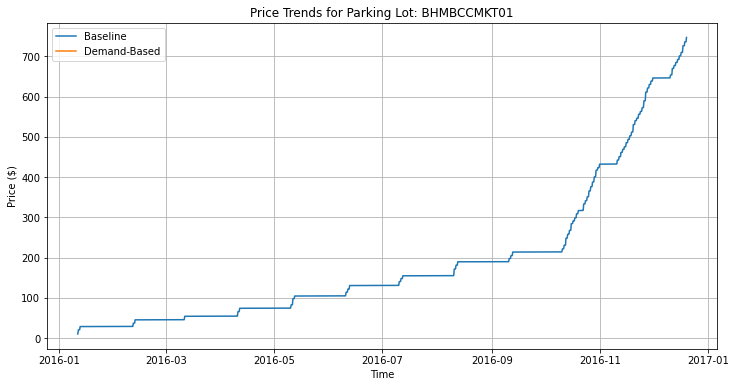

In [21]:
import matplotlib.pyplot as plt

lot = df['SystemCodeNumber'].unique()[0]

plt.figure(figsize=(12, 6))
plt.plot(df_baseline[df_baseline['SystemCodeNumber'] == lot]['timestamp'],
         df_baseline[df_baseline['SystemCodeNumber'] == lot]['price'], label='Baseline')
plt.plot(df_demand[df_demand['SystemCodeNumber'] == lot]['timestamp'],
         df_demand[df_demand['SystemCodeNumber'] == lot]['price'], label='Demand-Based')
plt.xlabel("Time")
plt.ylabel("Price ($)")
plt.title(f"Price Trends for Parking Lot: {lot}")
plt.legend()
plt.grid(True)
plt.show()
